In [1]:
from qiskit import qpy
from qiskit.circuit import QuantumCircuit
from qiskit.primitives import StatevectorSampler
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
import numpy as np
import matplotlib.pyplot as plt
from QuditsOnQubits import create_ame43, create_graph_ghz, create_ghz
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_transpiler import generate_ai_pass_manager

from QuditsOnQubits.ai_ghz_transpilation import best_standard_qc

In [2]:
import igraph as ig

In [3]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

In [116]:
from qiskit.transpiler import TranspilerError
from qiskit.transpiler.preset_passmanagers.plugin import list_stage_plugins

In [160]:
backend = QiskitRuntimeService().backend("ibm_aachen")

In [5]:
aachen_coupling_map = backend.coupling_map

In [6]:
sq = ig.Graph()
sq.add_vertices(4)
sq.add_edges([(0, 1), (1, 2), (2, 3), (2, 3), (3, 0)])

In [7]:
ame43_qc = create_graph_ghz(sq)

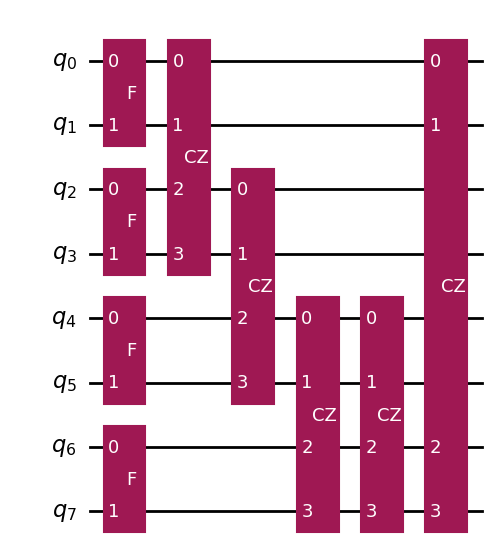

In [8]:
ame43_qc.draw('mpl')

In [9]:
with open('Zgate.qpy', 'rb') as fd:
    Zgate = qpy.load(fd)[0]

with open('Xgate.qpy', 'rb') as fd:
    Xgate = qpy.load(fd)[0]

with open('Fgate.qpy', 'rb') as fd:
    Fgate = qpy.load(fd)[0]

with open('CZ.qpy', 'rb') as fd:
    CZgate = qpy.load(fd)[0]

with open('FDAGgate.qpy', 'rb') as fd:
    FDAGgate = qpy.load(fd)[0]

In [114]:
'''
Stabilizator X Z I Z
'''

stab_ame43_1 = QuantumCircuit(8)
stab_ame43_1.append(Xgate, [0, 1])
stab_ame43_1.append(Zgate, [2, 3])
stab_ame43_1.append(Zgate, [6, 7])

#op_ame43_1 = SparsePauliOp.from_operator(Operator(stab_ame43_1))

'''
Stabilizator XZ ZX Z Z
'''

stab_ame43_2 = QuantumCircuit(8)
stab_ame43_2.append(Xgate, [0, 1])
stab_ame43_2.append(Zgate, [0, 1])
stab_ame43_2.append(Zgate, [2, 3])
stab_ame43_2.append(Xgate, [2, 3])
stab_ame43_2.append(Zgate, [4, 5])
stab_ame43_2.append(Zgate, [6, 7])

#op_ame43_2 = SparsePauliOp.from_operator(Operator(stab_ame43_2))

'''
Stabilizator XZZ ZXX ZZ Z
'''

stab_ame43_3 = QuantumCircuit(8)
stab_ame43_3.append(Xgate, [0, 1])
stab_ame43_3.append(Zgate, [0, 1])
stab_ame43_3.append(Zgate, [0, 1])
stab_ame43_3.append(Zgate, [2, 3])
stab_ame43_3.append(Xgate, [2, 3])
stab_ame43_3.append(Xgate, [2, 3])
stab_ame43_3.append(Zgate, [4, 5])
stab_ame43_3.append(Zgate, [4, 5])
stab_ame43_3.append(Zgate, [6, 7])

#op_ame43_3 = SparsePauliOp.from_operator(Operator(stab_ame43_3))

'''
Stabilizator I Z X ZZ
'''

stab_ame43_4 = QuantumCircuit(8)
stab_ame43_4.append(Zgate, [2, 3])
stab_ame43_4.append(Xgate, [4, 5])
stab_ame43_4.append(Zgate, [6, 7])
stab_ame43_4.append(Zgate, [6, 7])

#op_ame43_4 = SparsePauliOp.from_operator(Operator(stab_ame43_4))

'''
Stabilizator XZ Z ZZ ZX
'''

stab_ame43_5 = QuantumCircuit(8)
stab_ame43_5.append(Xgate, [0, 1])
stab_ame43_5.append(Zgate, [0, 1])
stab_ame43_5.append(Zgate, [2, 3])
stab_ame43_5.append(Zgate, [4, 5])
stab_ame43_5.append(Zgate, [4, 5])
stab_ame43_5.append(Zgate, [6, 7])
stab_ame43_5.append(Xgate, [6, 7])

#op_ame43_5 = SparsePauliOp.from_operator(Operator(stab_ame43_5))

In [11]:
from qiskit_ibm_transpiler.transpiler_service import TranspilerService

In [14]:
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

In [15]:
from qiskit.transpiler.preset_passmanagers.plugin import list_stage_plugins

In [16]:
list_stage_plugins("translation")

['default',
 'synthesis',
 'translator',
 'ibm_backend',
 'ibm_dynamic_circuits',
 'ibm_fractional']

In [21]:
pm = generate_preset_pass_manager(target=target, optimization_level=3, translation_method='ibm_fractional')
isa_ame43_qc = pm.run(ame43_qc)

In [22]:
isa_ame43_qc.depth()

218

In [23]:
ai_transpiler_pass_manager = generate_ai_pass_manager(
    backend=backend,
    ai_optimization_level=3,
    optimization_level=3,
    ai_layout_mode="optimize",
)

In [24]:
isa_ame43_qc_ai = ai_transpiler_pass_manager.run(ame43_qc)

In [25]:
isa_ame43_qc_ai.depth()

198

In [26]:
isa_ame43_qc_ai2 = ai_transpiler_pass_manager.run(ame43_qc)
isa_ame43_qc_ai2.depth()

INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode


168

In [28]:
best_isa_qc = isa_ame43_qc_ai2.copy()

for i in range(100):
    isa_ame43_qc_ai2 = ai_transpiler_pass_manager.run(ame43_qc)
    if isa_ame43_qc_ai2.depth() <= best_isa_qc.depth():
        best_isa_qc = isa_ame43_qc_ai2.copy()
        print(isa_ame43_qc_ai2.depth())

INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode


176


INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode


169


INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode


169


INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode


166


INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode


159


INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.a

157


INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.a

In [29]:
best_isa_qc.depth()

157

In [118]:
def translation_opti(qc):
    list_plugins = list_stage_plugins("translation")

    list_of_best = np.zeros(len(list_plugins))
    k = 0
    pm_trans = generate_preset_pass_manager(target=target, optimization_level=3, translation_method=list_plugins[0])
    best_qc = pm_trans.run(qc)
    for name_plugin in list_plugins:
        try:
            print(f'-------- {name_plugin} --------')
            for i in range(100):
                temp_qc = pm_trans.run(qc)
                if temp_qc.depth() < best_qc.depth():
                    best_qc = temp_qc.copy()
                    list_of_best[k] = best_qc.depth()
                    print(best_qc.depth())
        except TranspilerError:
            print(f'TranspilerError {name_plugin}')
            continue
    return best_qc


In [119]:
best_standard_ame43_qc = translation_opti(ame43_qc)

-------- default --------
239
236
226
221
218
203
200
-------- synthesis --------
195
191
-------- translator --------
-------- ibm_backend --------
-------- ibm_dynamic_circuits --------
-------- ibm_fractional --------


In [120]:
best_standard_ame43_qc.depth()

191

In [121]:
ame43_observables_A_ai = []
ame43_observables_B_ai = []
ame43_observables_A_standard = []
ame43_observables_B_standard = []
ops_ame43_observables = [stab_ame43_1, stab_ame43_2, stab_ame43_3, stab_ame43_4, stab_ame43_5]



for op in ops_ame43_observables:

    op = Operator(op)

    A_op = (0.5 * (op + op.adjoint()))
    B_op = (-0.5j * (op - op.adjoint()))

    A = SparsePauliOp.from_operator(A_op)
    B = SparsePauliOp.from_operator(B_op)

    isa_op_temp_A_ai = A.apply_layout(layout=best_isa_qc.layout)
    isa_op_temp_B_ai = B.apply_layout(layout=best_isa_qc.layout)

    ame43_observables_A_ai.append([isa_op_temp_A_ai])
    ame43_observables_B_ai.append([isa_op_temp_B_ai])

    isa_op_temp_A_stand = A.apply_layout(layout=best_standard_ame43_qc.layout)
    isa_op_temp_B_stand = B.apply_layout(layout=best_standard_ame43_qc.layout)

    ame43_observables_A_standard.append([isa_op_temp_A_stand])
    ame43_observables_B_standard.append([isa_op_temp_B_stand])

In [126]:
np.iscomplexobj(np.real_if_close(ame43_observables_A_standard[0][0].coeffs))

False

In [127]:
est = AerEstimator()
est.options.default_shots = 10_000

In [131]:
exp_val_ai = []

for op in ame43_observables_A_ai:
    job = est.run(best_isa_qc, op)
    exp_val = job.result().values[0]
    exp_val_ai.append(exp_val.round(3))

In [132]:
exp_val_ai

[np.float64(1.007),
 np.float64(1.007),
 np.float64(0.985),
 np.float64(1.022),
 np.float64(0.979)]

In [133]:
exp_val_stand = []

for op in ame43_observables_A_standard:
    job = est.run(best_standard_ame43_qc, op)
    exp_val = job.result().values[0]
    exp_val_stand.append(exp_val.round(3))

exp_val_stand

[np.float64(0.968),
 np.float64(0.986),
 np.float64(0.982),
 np.float64(0.987),
 np.float64(1.038)]

In [42]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator

In [43]:
estimator = Estimator(mode=backend)

In [134]:
pub = (best_isa_qc, ame43_observables_A_ai)

job_result_ame43_A_ai = estimator.run(pubs=[pub]).result()
job_result_ame43_A_ai[0].data.evs

array([[0.79988748],
       [0.68295131],
       [0.68044895],
       [0.77461453],
       [0.71074092]])

In [135]:
pub = (best_standard_ame43_qc, ame43_observables_A_standard)

job_result_ame43_A_standard = estimator.run(pubs=[pub]).result()
job_result_ame43_A_standard[0].data.evs

array([[0.76689233],
       [0.74783746],
       [0.75706263],
       [0.8227737 ],
       [0.72963351]])

In [137]:
from qiskit.transpiler.passes.scheduling import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
)
from qiskit.transpiler import PassManager

In [138]:
from qiskit.visualization import timeline_drawer

In [141]:
from qiskit.circuit.library import XGate, YGate

X = XGate()
Y = YGate()

dd_sequence = [X, Y, X, Y]

In [161]:
target = backend.target

basis_gates = list(target.operation_names)
basis_gates

['id', 'delay', 'measure', 'sx', 'rz', 'cz', 'reset', 'x']

In [162]:
from qiskit.transpiler import InstructionProperties

y_gate_properties = {}
for qubit in range(target.num_qubits):
    y_gate_properties.update(
        {
            (qubit,): InstructionProperties(
                duration=target["x"][(qubit,)].duration,
                error=target["x"][(qubit,)].error,
            )
        }
    )

target.add_instruction(YGate(), y_gate_properties)

In [163]:
dd_pm = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        PadDynamicalDecoupling(target=target, dd_sequence=dd_sequence),
    ]
)

In [164]:
qc_ai_dd = dd_pm.run(best_isa_qc)

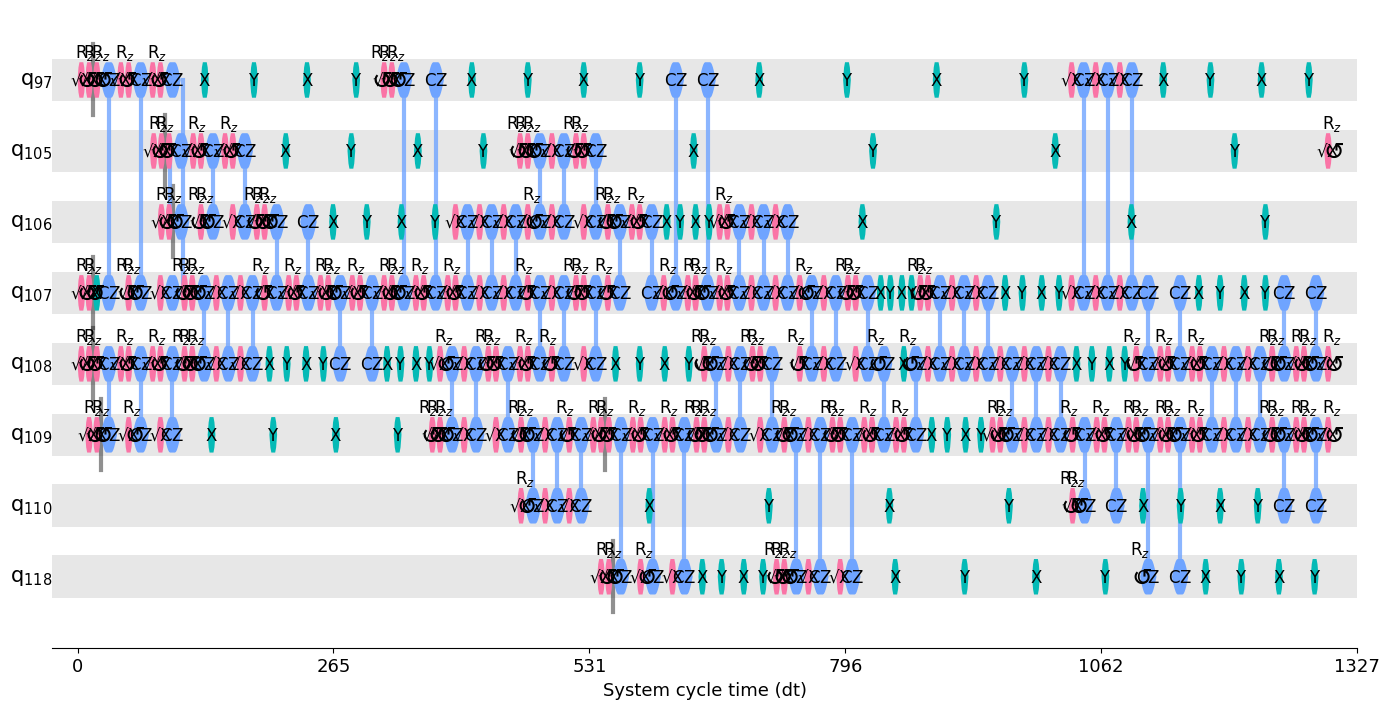

In [165]:
timeline_drawer(qc_ai_dd, idle_wires=False, target=target)

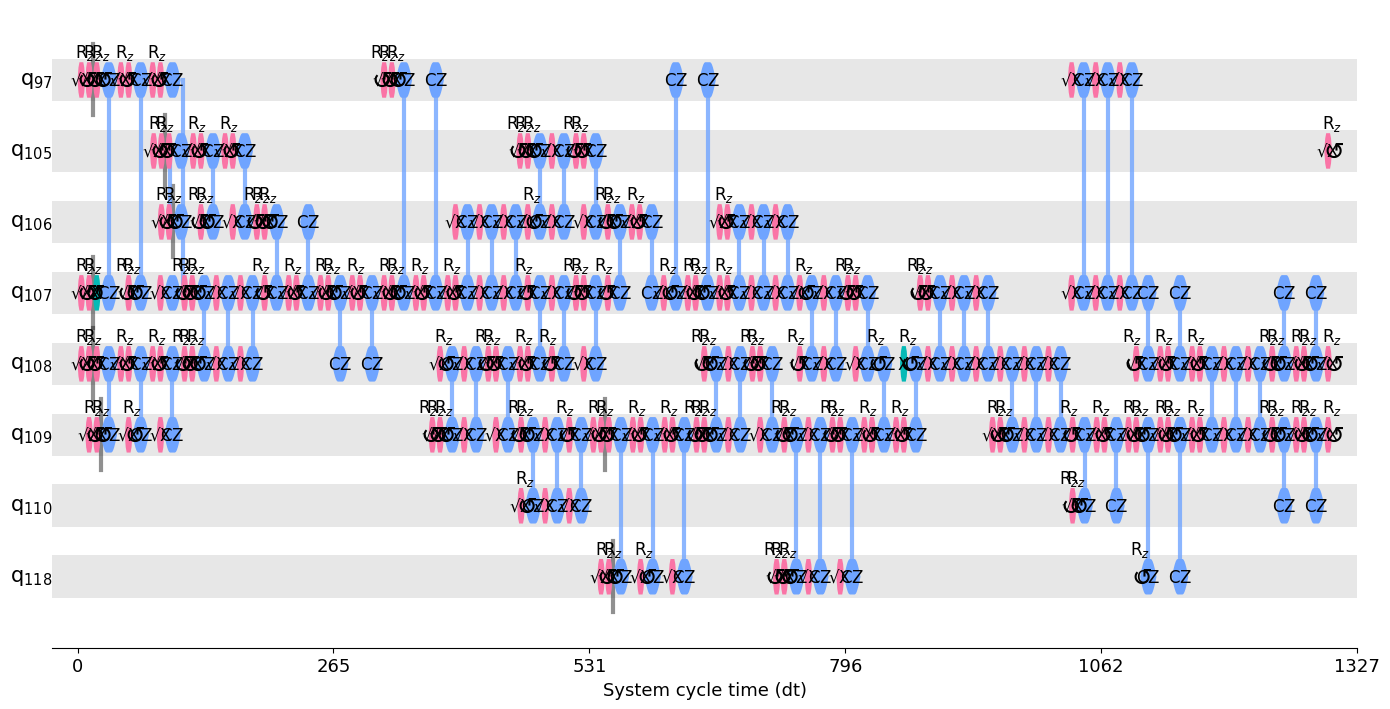

In [166]:
timeline_drawer(best_isa_qc, idle_wires=False, target=target)

In [167]:
qc_standard_dd = dd_pm.run(best_standard_ame43_qc)

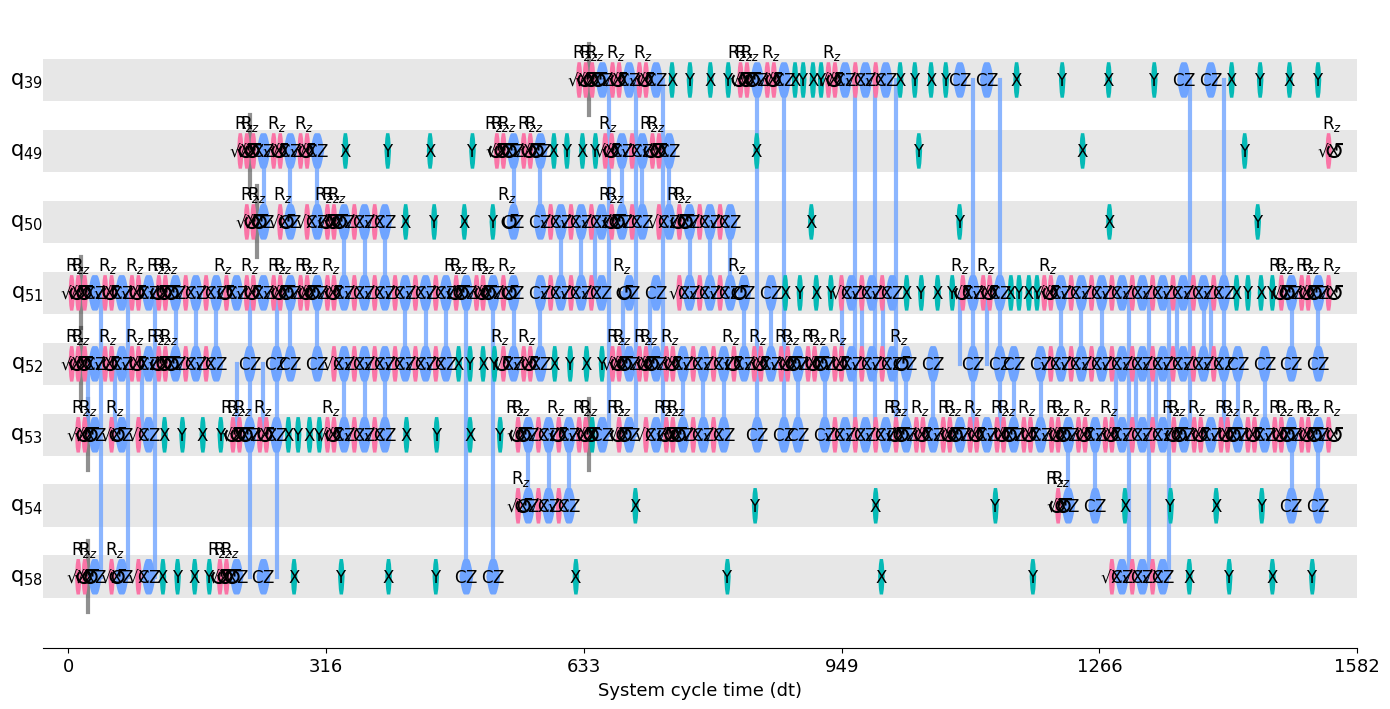

In [168]:
timeline_drawer(qc_standard_dd, idle_wires=False, target=target)

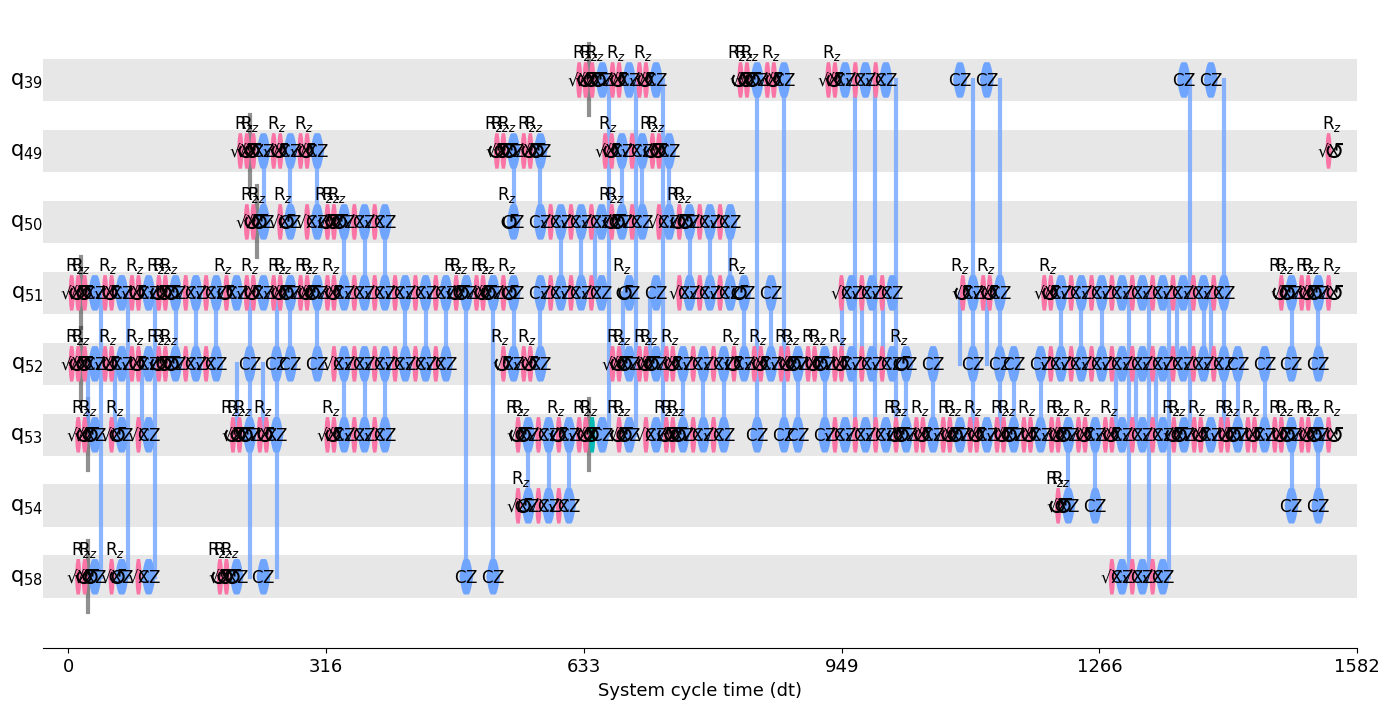

In [169]:
timeline_drawer(best_standard_ame43_qc, idle_wires=False, target=target)

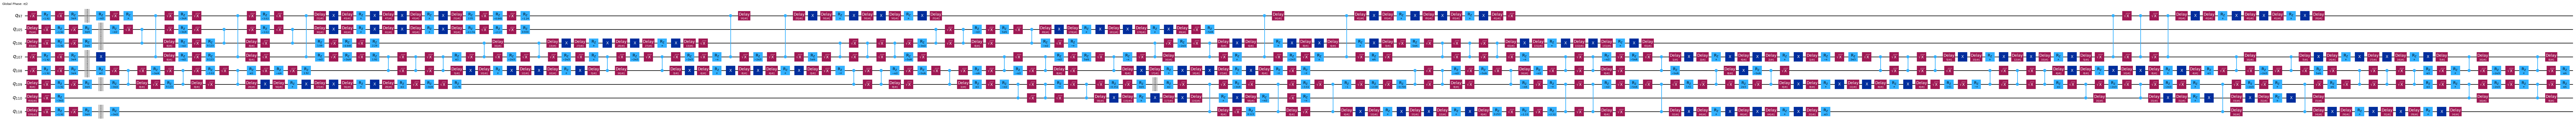

In [170]:
from qiskit.circuit.equivalence_library import (
    SessionEquivalenceLibrary as sel,
)
from qiskit.transpiler.passes import BasisTranslator

qc_ai_dd = BasisTranslator(sel, basis_gates)(qc_ai_dd)
qc_ai_dd.draw("mpl", fold=-1, idle_wires=False)

In [173]:
estimator.options.max_execution_time = 600

In [174]:
pub = (qc_ai_dd, ame43_observables_A_ai)

job_result_ame43_A_ai = estimator.run(pubs=[pub]).result()
job_result_ame43_A_ai[0].data.evs

array([[0.76249364],
       [0.64882449],
       [0.68859284],
       [0.77976544],
       [0.6650409 ]])

In [184]:
job_result_ame43_A_ai[0].data.stds

array([[0.01222923],
       [0.01272812],
       [0.01275534],
       [0.01140155],
       [0.01263375]])

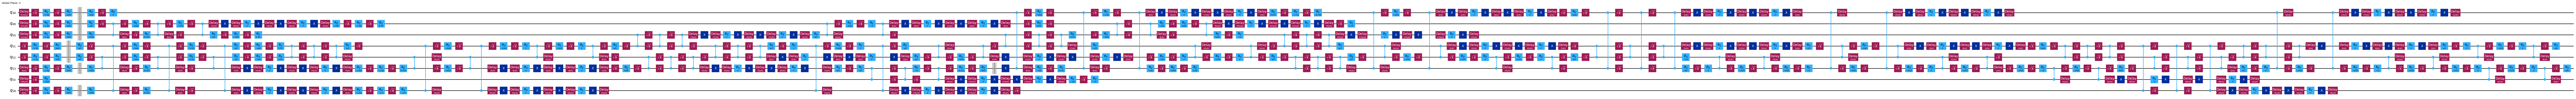

In [175]:
qc_standard_dd = BasisTranslator(sel, basis_gates)(qc_standard_dd)
qc_standard_dd.draw("mpl", fold=-1, idle_wires=False)

In [176]:
pub = (qc_standard_dd, ame43_observables_A_standard)

job_result_ame43_A_standard = estimator.run(pubs=[pub]).result()
job_result_ame43_A_standard[0].data.evs

array([[0.77059113],
       [0.72304465],
       [0.73721286],
       [0.8280874 ],
       [0.73416583]])

In [183]:
job_result_ame43_A_standard[0].data.stds

array([[0.0113839 ],
       [0.01302399],
       [0.01301765],
       [0.01266698],
       [0.01289191]])

In [178]:
G1_ai = job_result_ame43_A_ai[0].data.evs[0]
G1G2_ai = job_result_ame43_A_ai[0].data.evs[1]
G1G22_ai = job_result_ame43_A_ai[0].data.evs[2]
G3_ai = job_result_ame43_A_ai[0].data.evs[3]
G1G4_ai = job_result_ame43_A_ai[0].data.evs[4]

In [180]:
B_ai = G1_ai + G1G22_ai + 0.5 * (G1G2_ai + G1G4_ai) + G3_ai

In [181]:
B_ai * 2

array([5.77556922])